In [1]:
from cbt_preprocessing import CBTProcessor

# give path to text corpus and embeddings
data_loader = CBTProcessor('data/cbt_train.txt', 'data/glove.6B.50d.txt', 50)

Words extracted. Total number: 31614
Number of pre-trained: 31547


In [2]:
# prepare for batch generation on train and val splits
data_loader.fit_on_texts('data/cbtest_CN_train.txt', 'train')
data_loader.fit_on_texts('data/cbtest_CN_valid_2000ex.txt', 'val')

In [3]:
# check batch sampling
ex_batch_train = data_loader.sample_batch('train', 32)
data_loader.show_example(ex_batch_train)

DOC:
`` ah ! my mother , '' replied sadly , `` what did you promise , yourself ? '' the king of the gold mines , indignant at being kept from his happiness by this wicked old woman , went up to her , and threatening her with his sword , said : `` get away out of my country at once , and for ever , miserable creature , lest i take your life , and so rid myself of your malice . '' he had hardly spoken these words when the lid of the box fell back on the floor with a terrible noise , and to their horror out sprang the yellow dwarf , mounted upon a great cat . `` rash youth ! '' he cried , rushing between the fairy of the desert and the king . `` dare to lay a finger upon this illustrious fairy ! your quarrel is with me only . i am your enemy and your rival . that faithless princess who would have married you is promised to me . see if she has not upon her finger a ring made of one of my hairs . just try to take it off , and you will soon find out that i am more powerful than you are ! '' 

In [4]:
# each batch contains:
# docs and queries
ex_D_train, ex_Q_train = ex_batch_train[0], ex_batch_train[1]
print('Doc shape:', ex_D_train.shape)
print('Query shape:', ex_Q_train.shape)
# 10 possible candidates
ex_C_train = ex_batch_train[2]
print('-'*10)
print('Cands shape:', ex_C_train.shape)
# real answers
ex_A_train = ex_batch_train[3]
print('-'*10)
print('Answer shape:', ex_A_train.shape)
# Doc2Query Masks
ex_mask_train = ex_batch_train[4]
print('-'*10)
print('Mask shape:', ex_mask_train.shape)

Doc shape: (32, 1000)
Query shape: (32, 150)
----------
Cands shape: (32, 10)
----------
Answer shape: (32,)
----------
Mask shape: (32, 1000, 150)


# Memory Network

In [5]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, data_loader.max_doc_len], name='Doc')
q = tf.placeholder(tf.int32, [None, data_loader.max_query_len], name='Query')
a = tf.placeholder(tf.int32, [None,], name='Answer')

A_emb = tf.Variable(data_loader.embeddings, name='Doc_embeddings')
B_emb = tf.Variable(data_loader.embeddings, name='Query_embeddings')
C_emb = tf.Variable(data_loader.embeddings, name='Output_embeddings')

m = tf.nn.embedding_lookup(A_emb, X, name='Memory_vector')
u = tf.reduce_mean(tf.nn.embedding_lookup(B_emb, q), 1, name='Internal_state')
p = tf.nn.softmax(m @ tf.reshape(u, shape=(-1,data_loader.embed_dim,1)), axis=1, name='Match_prob')
c = tf.nn.embedding_lookup(C_emb, X, name='Output_vector')

o = tf.reduce_sum(p * c, axis=1, name='Response_vector')

a_hat_logits = tf.layers.dense(o+u, len(data_loader.words), use_bias=False)
a_hat = tf.nn.softmax(a_hat_logits)

train_loss = tf.losses.sparse_softmax_cross_entropy(a, a_hat_logits)
acc_score = tf.contrib.metrics.accuracy(tf.argmax(a_hat, axis=1, output_type=tf.int32), a)

optim = tf.train.AdamOptimizer(learning_rate=1e-2)
train_op = optim.minimize(train_loss)
print(a_hat.shape)

(?, 31614)


In [12]:
data_loader.train_data_len

120769

In [13]:
def get_accuracy(sess, data_loader, batch_size=100):
    total_acc = 0
    for step in range(0, data_loader.val_data_len, batch_size):
        batch_val = data_loader.sample_batch('val', batch_size, offset=step)
        
        iacc = sess.run(acc_score, feed_dict={X:batch_val[0], q:batch_val[1], a:batch_val[3]})
        total_acc += iacc * batch_size
    return total_acc / data_loader.val_data_len

In [14]:
batch_size = 50
steps_per_epoch = 200
n_epochs = 20

train_losses = []
train_accs = []
val_accs = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(n_epochs)):
    print('-'*10)
    print('EPOCH:', epoch)
    
    ctrain_loss, ctrain_accuracy = 0, 0
    cval_accuracy = 0
    
    for step in range(steps_per_epoch):
        batch_train = data_loader.sample_batch('train', batch_size)
        
        _, iloss, iacc = sess.run([train_op, train_loss, acc_score], 
                                    feed_dict={X: batch_train[0], q: batch_train[1], a: batch_train[3]})
        
        ctrain_loss += iloss
        ctrain_accuracy += iacc
    
    ctrain_loss /= steps_per_epoch
    ctrain_accuracy /= steps_per_epoch
    cval_accuracy = get_accuracy(sess, data_loader)
    
    train_losses += [ctrain_loss]
    train_accs += [ctrain_accuracy]
    val_accs += [cval_accuracy]
    
    print('Train cross-entropy loss:', ctrain_loss)
    print('Train accuracy:', ctrain_accuracy)
    print('Val accuracy:', cval_accuracy)
    if len(val_accs) > 5 and cval_accuracy < np.mean(val_accs[-5:]):
        print('Finished')
        break

  0%|          | 0/20 [00:00<?, ?it/s]

----------
EPOCH: 0


  5%|▌         | 1/20 [01:06<20:55, 66.10s/it]

Train cross-entropy loss: 7.214302268028259
Train accuracy: 0.030699999406933784
Val accuracy: 0.05750000048428774
----------
EPOCH: 1


 10%|█         | 2/20 [02:16<20:28, 68.23s/it]

Train cross-entropy loss: 6.363027768135071
Train accuracy: 0.07019999926909805
Val accuracy: 0.09399999910965562
----------
EPOCH: 2


 15%|█▌        | 3/20 [03:26<19:29, 68.77s/it]

Train cross-entropy loss: 5.88478687286377
Train accuracy: 0.1037999995611608
Val accuracy: 0.11750000119209289
----------
EPOCH: 3


 20%|██        | 4/20 [04:35<18:21, 68.84s/it]

Train cross-entropy loss: 5.52139999628067
Train accuracy: 0.13189999943599104
Val accuracy: 0.1300000000745058
----------
EPOCH: 4


 25%|██▌       | 5/20 [05:42<17:06, 68.42s/it]

Train cross-entropy loss: 5.291783566474915
Train accuracy: 0.14940000016242266
Val accuracy: 0.14549999926239252
----------
EPOCH: 5


 30%|███       | 6/20 [06:46<15:48, 67.78s/it]

Train cross-entropy loss: 5.0981640625
Train accuracy: 0.16360000059008598
Val accuracy: 0.15149999894201754
----------
EPOCH: 6


 35%|███▌      | 7/20 [07:51<14:35, 67.36s/it]

Train cross-entropy loss: 4.880957601070404
Train accuracy: 0.18239999927580355
Val accuracy: 0.15250000022351742
----------
EPOCH: 7


 40%|████      | 8/20 [09:00<13:30, 67.58s/it]

Train cross-entropy loss: 4.729925467967987
Train accuracy: 0.18960000023245813
Val accuracy: 0.15449999868869782
----------
EPOCH: 8


 45%|████▌     | 9/20 [10:06<12:21, 67.37s/it]

Train cross-entropy loss: 4.559830129146576
Train accuracy: 0.20690000019967555
Val accuracy: 0.15650000032037498
----------
EPOCH: 9


 50%|█████     | 10/20 [11:12<11:12, 67.20s/it]

Train cross-entropy loss: 4.472157752513885
Train accuracy: 0.22070000045001506
Val accuracy: 0.1625
----------
EPOCH: 10
Train cross-entropy loss: 4.319539345502854
Train accuracy: 0.2278999998793006
Val accuracy: 0.1449999999254942
Finished


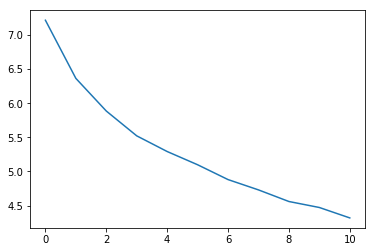

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.show()

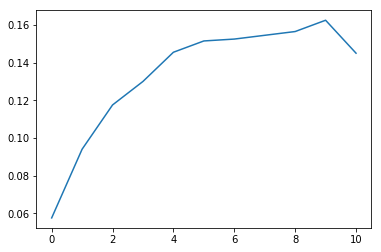

In [17]:
plt.plot(val_accs)
plt.show()